In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Embedding
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

In [2]:
tf.random.set_seed(42)

In [3]:
INPUT_DAYS = 10 # 用多少天來作為預測資料
TRAIN_PCT = 0.85 # 切分成訓練資料的比例
PREDICTION_WINDOWS = 7 # 預測日和我們的輸入間隔幾天

In [18]:
def showGraph(model, test_target):
    test_predictions = model.predict(test_feature).flatten()
    test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':test_target})
    print(f'MAPE: {mean_absolute_percentage_error(test_target, test_predictions)}')
    print(f'MSE: {mean_squared_error(test_target, test_predictions)}')
    print(f'MAE: {mean_absolute_error(test_target, test_predictions)}')
    test_results['difference'] = test_results['Actuals'] - test_results['Test Predictions']
    plt.plot(test_results['Test Predictions'], label='predictions')
    plt.plot(test_results['Actuals'], label='actual')
    plt.legend()
    plt.xlabel('Time (days)')
    plt.ylabel('Egg price (NTD)')
    plt.show()

### Read Files and Replace Null Value

In [5]:
## 新冠資料要2020後才有，禽流感則是2015，所以可能要權衡一下是否要增加欄位而放棄資料筆數，或是有什麼方法可以彌補資料不全的部分
FILE_PREFIX = 'data/'
FILES = ['72G600_WEATHER.csv', 'EGG_PRICE.csv', 'EGG_PRODUCTION.csv', 'WEED_PRICE.csv'] # 'COVID.csv', 'AVIAN_INFLUENZA.csv'
DATAFRAMES = []

for FILE in FILES:
    df = pd.read_csv(FILE_PREFIX+FILE, encoding='utf-8', index_col=False) # 從檔案讀取
    df = df.replace('休市', np.NaN) # 當雞蛋價格為休市視為空值
    df.fillna(method='pad', inplace=True) # 用前一筆資料補齊空的資料
    DATAFRAMES.append(df)

### Merge Data from Different Files

In [6]:
df_all = DATAFRAMES[0]
for i, DATAFRAME in enumerate(DATAFRAMES):
    if i == 0: continue
    if 'date' in DATAFRAME: df_all = df_all.merge(DATAFRAME, how='inner', on=['month', 'date']) # 都是日資料的合併
    else: df_all = pd.merge(df_all, DATAFRAME, left_on="month", right_on="month") # 日資料及月資料的合併 (目前同一個月就都用一樣的數值)
df_all['egg_price'] = pd.to_numeric(df_all['egg_price'])
df_all = pd.get_dummies(df_all, columns=["lunar_date"]) # 農曆日期這邊看成categorical feature，所以用one hot encoding的方式

In [7]:
df_all

,month,date,avg_temperature,max_temperature,min_temperature,rainfall,sunshine,white_broiler_big,white_broiler_mid,white_broiler_retail,...,lunar_date_1221,lunar_date_1222,lunar_date_1223,lunar_date_1224,lunar_date_1225,lunar_date_1226,lunar_date_1227,lunar_date_1228,lunar_date_1229,lunar_date_1230
0,201101,1,11.6,18.8,6.6,0.0,7.7,26,26.5,28,...,0,0,0,0,0,0,0,0,0,0
1,201101,2,13.6,20.1,8.1,0.0,7.2,26,26.5,28,...,0,0,0,0,0,0,0,0,0,0
2,201101,3,13.7,16.5,11.6,0.0,0.8,26,26.5,28,...,0,0,0,0,0,0,0,0,0,0
3,201101,4,14.5,19.1,12.0,0.0,6.2,26.3,26.8,28.3,...,0,0,0,0,0,0,0,0,0,0
4,201101,5,16.9,23.3,12.1,3.0,7.4,26.3,26.8,28.3,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4072,202202,24,14.8,18.3,12.1,0.0,8.5,31.8,31.8,33.3,...,0,0,0,0,0,0,0,0,0,0
4073,202202,25,16.2,20.8,11.9,0.0,9.0,31.8,31.8,33.3,...,0,0,0,0,0,0,0,0,0,0
4074,202202,26,17.0,21.6,13.0,0.0,10.1,31.8,31.8,33.3,...,0,0,0,0,0,0,0,0,0,0
4075,202202,27,18.8,25.3,13.5,0.0,9.4,31.8,31.8,33.3,...,0,0,0,0,0,0,0,0,0,0


### Data Normalization

In [8]:
columns = df_all.columns.to_list()
columns.remove('month') # 移除非訓練欄位的部分
columns.remove('date')
scaler = MinMaxScaler(feature_range=(0, 1)) # normalization
scaled_feature = scaler.fit_transform(df_all[columns])
target_value = df_all['egg_price'].to_numpy() # 目標欄位為蛋價


In [9]:
DATA_COUNT = len(scaled_feature)
FEATURE_COUNT = len(scaled_feature[0])
print(f'Data Count: {DATA_COUNT}\nFeature Count: {FEATURE_COUNT}')

Data Count: 4077
Feature Count: 381


In [10]:
scaled_feature.shape, target_value.shape

((4077, 381), (4077,))

In [11]:
# Avoid tensorflow use full memory
physical_devices = tf.config.experimental.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

2022-05-18 21:43:59.245944: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-05-18 21:43:59.270752: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-18 21:43:59.271036: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.62GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2022-05-18 21:43:59.271190: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-05-18 21:43:59.272371: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-05-18 21:43:59.273472: I tensorflow/stream_executor/platform/de

DNN

In [12]:
train_feature = scaled_feature[0:int(DATA_COUNT*TRAIN_PCT)]
train_target = target_value[INPUT_DAYS:int(DATA_COUNT*TRAIN_PCT)+INPUT_DAYS]
test_feature = scaled_feature[int(DATA_COUNT*TRAIN_PCT):len(scaled_feature)-INPUT_DAYS]
test_target = target_value[int(DATA_COUNT*TRAIN_PCT)+INPUT_DAYS:]

In [13]:
INPUT_DAYS, int(DATA_COUNT*TRAIN_PCT)+INPUT_DAYS

(10, 3475)

In [14]:
train_feature.shape, train_target.shape, test_feature.shape, test_target.shape

((3465, 381), (3465,), (602, 381), (602,))

2022-05-18 21:28:26.795423: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-05-18 21:28:26.816101: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 3199980000 Hz
2022-05-18 21:28:26.816468: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x559f13d1a2a0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-05-18 21:28:26.816484: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-05-18 21:28:26.816674: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-18 21:28:26.816951: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeF

Epoch 1/50
  1/217 [..............................] - ETA: 0s - loss: 26.5319

2022-05-18 21:28:27.455594: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


217/217 [==============================] - 0s 1ms/step - loss: 17.6981
Epoch 2/50
217/217 [==============================] - 0s 879us/step - loss: 3.6122
Epoch 3/50
217/217 [==============================] - 0s 820us/step - loss: 3.2316
Epoch 4/50
217/217 [==============================] - 0s 963us/step - loss: 2.8908
Epoch 5/50
217/217 [==============================] - 0s 1ms/step - loss: 2.5697
Epoch 6/50
217/217 [==============================] - 0s 959us/step - loss: 2.2756
Epoch 7/50
217/217 [==============================] - 0s 922us/step - loss: 2.0257
Epoch 8/50
217/217 [==============================] - 0s 927us/step - loss: 1.8519
Epoch 9/50
217/217 [==============================] - 0s 887us/step - loss: 1.7144
Epoch 10/50
217/217 [==============================] - 0s 947us/step - loss: 1.6293
Epoch 11/50
217/217 [==============================] - 0s 1ms/step - loss: 1.5779
Epoch 12/50
217/217 [==============================] - 0s 1ms/step - loss: 1.5436
Epoch 13/50
217/217

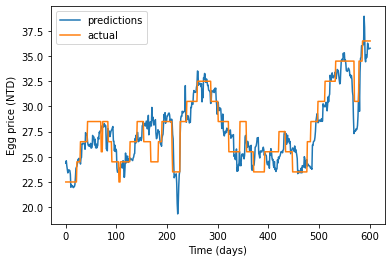

In [15]:
model = Sequential()
model.add(Dense(12, input_dim=(train_feature.shape[1]), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))

## predict label ##
# model.add(Dense(2, activation='softmax'))
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model.fit(train_feature, train_target_label, epochs=50, batch_size=16, validation_data=(test_feature, test_target_label))

## predict actual price ##
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')
model.fit(train_feature, train_target, epochs=50, batch_size=16)
showGraph(model, test_target)

### LSTM Model

In [12]:
feature = []
for i in range(len(scaled_feature)-INPUT_DAYS):
    feature.append(scaled_feature[i:i+INPUT_DAYS])
train_feature = np.array(feature[0:int(len(scaled_feature)*TRAIN_PCT)])
test_feature = np.array(feature[int(len(scaled_feature)*TRAIN_PCT):len(scaled_feature)-INPUT_DAYS-PREDICTION_WINDOWS])
train_target = target_value[PREDICTION_WINDOWS+INPUT_DAYS:int(DATA_COUNT*TRAIN_PCT)+PREDICTION_WINDOWS+INPUT_DAYS]
test_target = target_value[int(DATA_COUNT*TRAIN_PCT)+PREDICTION_WINDOWS+INPUT_DAYS:]



In [13]:
train_feature.shape, train_target.shape, test_feature.shape, test_target.shape

((3465, 10, 381), (3465,), (595, 10, 381), (595,))

Epoch 1/20
109/109 [==============================] - 2s 15ms/step - loss: 6.6173
Epoch 2/20
109/109 [==============================] - 2s 14ms/step - loss: 1.8934
Epoch 3/20
109/109 [==============================] - 2s 14ms/step - loss: 1.6547
Epoch 4/20
109/109 [==============================] - 2s 14ms/step - loss: 1.5315
Epoch 5/20
109/109 [==============================] - 2s 14ms/step - loss: 1.4391
Epoch 6/20
109/109 [==============================] - 2s 14ms/step - loss: 1.4380
Epoch 7/20
109/109 [==============================] - 2s 14ms/step - loss: 1.4471
Epoch 8/20
109/109 [==============================] - 2s 14ms/step - loss: 1.3228
Epoch 9/20
109/109 [==============================] - 2s 14ms/step - loss: 1.3146
Epoch 10/20
109/109 [==============================] - 2s 14ms/step - loss: 1.3125
Epoch 11/20
109/109 [==============================] - 2s 14ms/step - loss: 1.1754
Epoch 12/20
109/109 [==============================] - 2s 16ms/step - loss: 1.1538
Epoch 13/20
1

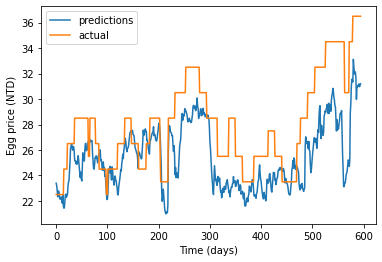

In [27]:
model = Sequential()
model.add(Dense(128, input_shape=(train_feature.shape[1:])))
model.add(Bidirectional(LSTM(128, input_shape=(train_feature.shape[1:]), activation='relu', return_sequences=True)))
model.add(SeqWeightedAttention())
# model.add(tf.keras.layers.MaxPooling1D(
#     pool_size=INPUT_DAYS, strides=None, data_format='channels_first'
# ))
# model.add(Dropout(0.2))
# model.add(LSTM(128, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.2))

## predict actual price ##
model.add(Dense(1))
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-5)
model.compile(optimizer=optimizer, loss='mae')
model.fit(train_feature, train_target, epochs=20)
showGraph(model, test_target)

In [24]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 10, 128)           48896     
_________________________________________________________________
bidirectional_6 (Bidirection (None, 10, 256)           263168    
_________________________________________________________________
seq_weighted_attention_1 (Se (None, 256)               257       
_________________________________________________________________
dense_19 (Dense)             (None, 32)                8224      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 33        
Total params: 320,578
Trainable params: 320,578
Non-trainable params: 0
_________________________________________________________________


Bi-GRU

Epoch 1/20
109/109 [==============================] - 2s 19ms/step - loss: 6.6712
Epoch 2/20
109/109 [==============================] - 2s 18ms/step - loss: 1.9549
Epoch 3/20
109/109 [==============================] - 2s 17ms/step - loss: 1.6948
Epoch 4/20
109/109 [==============================] - 2s 18ms/step - loss: 1.5932
Epoch 5/20
109/109 [==============================] - 2s 18ms/step - loss: 1.4505
Epoch 6/20
109/109 [==============================] - 2s 17ms/step - loss: 1.4151
Epoch 7/20
109/109 [==============================] - 2s 17ms/step - loss: 1.4174
Epoch 8/20
109/109 [==============================] - 2s 17ms/step - loss: 1.4219
Epoch 9/20
109/109 [==============================] - 2s 19ms/step - loss: 1.3830
Epoch 10/20
109/109 [==============================] - 2s 19ms/step - loss: 1.3284
Epoch 11/20
109/109 [==============================] - 2s 18ms/step - loss: 1.3517
Epoch 12/20
109/109 [==============================] - 2s 18ms/step - loss: 1.3433
Epoch 13/20
1

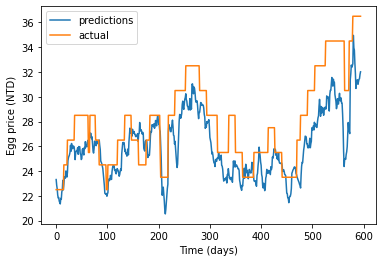

In [26]:
model = Sequential()
model.add(Dense(128, input_shape=(train_feature.shape[1:])))
model.add(Bidirectional(tf.keras.layers.GRU(128, input_shape=(train_feature.shape[1:]), activation='relu', return_sequences=True)))
model.add(SeqWeightedAttention())
model.add(Dense(32, activation='relu'))

## predict actual price ##
model.add(Dense(1))
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-5)
model.compile(optimizer=optimizer, loss='mae')
model.fit(train_feature, train_target, epochs=20)
showGraph(model, test_target)

In [21]:
model.summary()